<a href="https://colab.research.google.com/github/alcoleasnoelia/Proyecto1-IA-DigitalHouse-Grupo4/blob/master/Notebook%20lll%20-%20Redes_(text).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(Continuación de la notebook anterior)
Notebook 3
    
6.  Modelado Avanzado Neural Networks (LSTMs)
    *   Red Secuencial Inicial
    *   Red Secuencial con regularizaciómn 
    *   Modelado de Red con Cross Validation
    *   Análisis final de performance
7.  Conclusiones



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import re

#Librerias para generación de features
import string
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
#Librerias para construcción de red
from keras import losses
from keras import metrics
from keras import optimizers
from keras import models, layers
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.layers import Embedding
from keras import regularizers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Cargamos el dataset a partir del pickle generado por la notebook de limpieza:

In [0]:
news = pd.read_pickle("/content/drive/My Drive/Colab Notebooks/Desafio1Local/news_.p")

In [0]:
news.head(5)

,title,text,subject,date,text_st,fakenews_,title_clean,text_clean,text_polarity,text_subjectivity,title_polarity,title_subjectivity,text_clean_polarity,text_clean_subjectivity,title_clean_polarity,title_clean_subjectivity
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",washington (reuters) - the head of a conserv r...,0,us budget fight looms republicans flip fiscal ...,head conservative republican faction us congre...,0.037083,0.410250,0.00,0.0,0.036979,0.403438,0.0,0.00
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",washington (reuters) - transgend peopl will be...,0,us military accept transgender recruits monday...,transgender people allowed first time enlist u...,0.055880,0.298557,-0.10,0.1,0.113095,0.296168,-0.1,0.10
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",washington (reuters) - the special counsel inv...,0,senior us republican senator let mr mueller job,special counsel investigation links russia pre...,0.115930,0.316798,0.00,0.0,0.129766,0.311252,0.0,0.00
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",washington (reuters) - trump campaign advis ge...,0,fbi russia probe helped australian diplomat ti...,trump campaign adviser george papadopoulos tol...,0.035968,0.306569,0.00,0.0,0.030305,0.276323,0.0,0.00
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",seattle/washington (reuters) - presid donald t...,0,trump wants postal service charge much amazon ...,president donald trump called us postal servic...,0.030093,0.399891,0.35,0.3,0.042130,0.379259,0.2,0.15


Dividimos el dataset en train y test con shuffle y estratificación:

In [0]:
data_train, data_test = train_test_split(news,test_size=0.30,shuffle=True,random_state=10, stratify=news["fakenews_"])

data_train = data_train.copy()
data_test = data_test.copy() 
print("data train shape: {}".format(data_train.shape))
print("data test shape: {}".format(data_test.shape))

data train shape: (31428, 16)
data test shape: (13470, 16)


In [0]:
def correr_stemming(text):
    # Stemming
    text = text.split()
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in text]
    text = " ".join(stemmed_words)
    return(text)

In [0]:
X_train=data_train["text_clean"].apply(correr_stemming)
X_test=data_test["text_clean"].apply(correr_stemming)
y_train=data_train["fakenews_"].copy()
y_test=data_test["fakenews_"].copy()

In [0]:
X_train_partial=X_train[8000:]
X_val=X_train[:8000]
y_val=y_train[:8000]
y_train_partial=y_train[8000:]

In [0]:
X_train_partial.shape, X_val.shape, X_test.shape

((23428,), (8000,), (13470,))

A partir de una vectorizacion por TFIDF obtenemos features delimitadas por las frecuencias
Frecuencia Máxima 80%
Frecuencia Mínima 2%

quedarán en nuestro modelo 1422 Features

In [0]:
tfidf_vec= TfidfVectorizer(stop_words='english', max_df=0.8, min_df=0.02)

In [0]:
X_train_partial_vec=tfidf_vec.fit_transform(X_train_partial).copy()
X_val_vec=tfidf_vec.transform(X_val).copy()
X_test_vec=tfidf_vec.transform(X_test).copy()
X_train_partial_vec.shape, X_val_vec.shape, X_test_vec.shape, y_test.shape

((23428, 1422), (8000, 1422), (13470, 1422), (13470,))

In [0]:
(X_train_partial_vec.shape[1],)

(1422,)

# **6.   Modelado Avanzado Neural Networks (LSTMs)**

Definimos una función para la construcción del modelo de capas densas:

In [0]:
def build_model(input_shape, layers=[15,10,1], optimizer='rmsprop'):
    # Instanciamos la clase del modelo secuencial
    model = Sequential(name='Modelo de base')
    
    #Configuramos la primera capa para que tome las features, con regularizacion l1
    model.add(Dense(layers[0], activation='relu', input_shape=(X_train_partial_vec.shape[1],), kernel_regularizer=regularizers.l1(0.001)))
    model.add(Dropout(0.5))

    for l in layers[1:-1]:
        model.add(Dense(units=l, activation='relu'))
        model.add(Dropout(0.5))

    # Agregamos la última capa 
    model.add(Dense(units=layers[-1], activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
    # Retornamos el modelo compilado
    return model


Realizamos una busqueda por iteraciones para encontrar los mejores hiperparametros 

In [0]:
from keras import optimizers

In [0]:
# Definimos la "grilla" de parámetros que vamos a explorar
layers = [[512, 10, 1], [64, 32,10, 1]]
optimizers = [ optimizers.SGD(momentum=0.9, nesterov=True), optimizers.Adam(), optimizers.RMSprop()]

In [0]:
import itertools
combinaciones = list(itertools.product(layers, optimizers))
combinaciones

[([512, 10, 1], <keras.optimizers.SGD at 0x7f535fc21320>),
 ([512, 10, 1], <keras.optimizers.Adam at 0x7f535fc21be0>),
 ([512, 10, 1], <keras.optimizers.RMSprop at 0x7f535fc21390>),
 ([64, 32, 10, 1], <keras.optimizers.SGD at 0x7f535fc21320>),
 ([64, 32, 10, 1], <keras.optimizers.Adam at 0x7f535fc21be0>),
 ([64, 32, 10, 1], <keras.optimizers.RMSprop at 0x7f535fc21390>)]

In [0]:
# Definamos algunas variables
n_splits = 3
batch_size = 3000
epochs = 60
verbose = 1

Creamos una lista vacía para ir guardando los entrenamientos y luego ejecutamos la función de cross validation para la selección del modelo con mejor arquitectura y optimizadores según su accuracy:

In [0]:
global_history = []

In [0]:
# Importamos KFold para hacer cross-validation
from sklearn.model_selection import KFold

# Instanciamos el objeto KFold
kfold = KFold(n_splits=n_splits, shuffle=False)

# Recorremos las combinaciones y generamos distintos modelos a ensayar
for (layers, optimizer) in combinaciones:
    print('\n\nEnsayando modelo con estructura {} y optimizador {}'.format(layers, optimizer))
    
    # Construimos el modelo
    
    model = build_model(input_shape=X_train_partial_vec.shape, layers=layers, optimizer=optimizer)
    
    # Guardamos los pesos iniciales para usarlos en cada fold
    model.save_weights('initial_weights.h5')
    
    # Generamos los sets de train y val para ensayar el modelo
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_partial_vec)):
        
        # Reiniciamos los pesos del modelo
        model.load_weights('initial_weights.h5')
        
        print(X_train_partial_vec.shape, X_val_vec.shape, X_test_vec.shape, y_train_partial.shape, y_val.shape, y_test.shape)       
        
        
        # Lo entrenamos con el split de x_train e y_train correspondiente
        history = model.fit(x=X_train_partial_vec,
                            y=y_train_partial,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(X_val_vec, y_val),
                            verbose=verbose
                           )
        
        
        
        # Evaluamos en train y en val (estos mismos valores los podemos sacar de history)
        train_loss, train_acc = model.evaluate(X_train_partial_vec, y_train_partial)
        val_loss, val_acc = model.evaluate(X_val_vec, y_val)
        
        # Agregamos esta corrida a la historia global
        global_history.append({'fold':fold, 
                               'layers':layers,
                               'optimizer':optimizer,
                               'train_loss':train_loss,
                               'train_acc':train_acc,
                               'val_loss':val_loss,
                               'val_acc':val_acc,
                               'history':history
                              })



Ensayando modelo con estructura [512, 10, 1] y optimizador <keras.optimizers.SGD object at 0x7f535fc21320>
(23428, 1422) (8000, 1422) (13470, 1422) (23428,) (8000,) (13470,)
Train on 23428 samples, validate on 8000 samples
Epoch 1/60
23428/23428 [==============================] - 2s 79us/step - loss: 20.8881 - binary_accuracy: 0.5092 - val_loss: 20.7231 - val_binary_accuracy: 0.5238
Epoch 2/60
23428/23428 [==============================] - 1s 60us/step - loss: 20.5478 - binary_accuracy: 0.5236 - val_loss: 20.2895 - val_binary_accuracy: 0.5309
Epoch 3/60
23428/23428 [==============================] - 1s 59us/step - loss: 20.0765 - binary_accuracy: 0.5414 - val_loss: 19.7814 - val_binary_accuracy: 0.5220
Epoch 4/60
23428/23428 [==============================] - 1s 60us/step - loss: 19.5540 - binary_accuracy: 0.5460 - val_loss: 19.2461 - val_binary_accuracy: 0.5194
Epoch 5/60
23428/23428 [==============================] - 1s 59us/step - loss: 19.0148 - binary_accuracy: 0.5451 - val_loss

Generamos un dataframe con las métricas por fold para luego seleccionar los mejores resultados:

In [0]:
import pandas as pd
df = pd.DataFrame(global_history)
df.head()

,fold,layers,optimizer,train_loss,train_acc,val_loss,val_acc,history
0,0,"[512, 10, 1]",<keras.optimizers.SGD object at 0x7f535fc21320>,1.011484,0.923980,1.008805,0.923250,<keras.callbacks.callbacks.History object at 0...
1,1,"[512, 10, 1]",<keras.optimizers.SGD object at 0x7f535fc21320>,0.917846,0.925090,0.915105,0.924375,<keras.callbacks.callbacks.History object at 0...
2,2,"[512, 10, 1]",<keras.optimizers.SGD object at 0x7f535fc21320>,0.920403,0.924364,0.917640,0.924875,<keras.callbacks.callbacks.History object at 0...
3,0,"[512, 10, 1]",<keras.optimizers.Adam object at 0x7f535fc21be0>,0.364087,0.956761,0.364975,0.953875,<keras.callbacks.callbacks.History object at 0...
4,1,"[512, 10, 1]",<keras.optimizers.Adam object at 0x7f535fc21be0>,0.328470,0.962865,0.330700,0.961000,<keras.callbacks.callbacks.History object at 0...


In [0]:
df.head(19)

,fold,layers,optimizer,train_loss,train_acc,val_loss,val_acc,history
0,0,"[512, 10, 1]",<keras.optimizers.SGD object at 0x7f535fc21320>,1.011484,0.923980,1.008805,0.923250,<keras.callbacks.callbacks.History object at 0...
1,1,"[512, 10, 1]",<keras.optimizers.SGD object at 0x7f535fc21320>,0.917846,0.925090,0.915105,0.924375,<keras.callbacks.callbacks.History object at 0...
2,2,"[512, 10, 1]",<keras.optimizers.SGD object at 0x7f535fc21320>,0.920403,0.924364,0.917640,0.924875,<keras.callbacks.callbacks.History object at 0...
3,0,"[512, 10, 1]",<keras.optimizers.Adam object at 0x7f535fc21be0>,0.364087,0.956761,0.364975,0.953875,<keras.callbacks.callbacks.History object at 0...
4,1,"[512, 10, 1]",<keras.optimizers.Adam object at 0x7f535fc21be0>,0.328470,0.962865,0.330700,0.961000,<keras.callbacks.callbacks.History object at 0...
5,2,"[512, 10, 1]",<keras.optimizers.Adam object at 0x7f535fc21be0>,0.318716,0.964274,0.322141,0.961625,<keras.callbacks.callbacks.History object at 0...
6,0,"[512, 10, 1]",<keras.optimizers.RMSprop object at 0x7f535fc2...,0.695128,0.918089,0.694048,0.918500,<keras.callbacks.callbacks.History object at 0...
7,1,"[512, 10, 1]",<keras.optimizers.RMSprop object at 0x7f535fc2...,0.729016,0.919498,0.728890,0.916750,<keras.callbacks.callbacks.History object at 0...
8,2,"[512, 10, 1]",<keras.optimizers.RMSprop object at 0x7f535fc2...,0.721967,0.909339,0.720383,0.907500,<keras.callbacks.callbacks.History object at 0...
9,0,"[64, 32, 10, 1]",<keras.optimizers.SGD object at 0x7f535fc21320>,0.529459,0.944682,0.526551,0.947125,<keras.callbacks.callbacks.History object at 0...


Verificamos que el maximo accuracy en validacion se obtuvo en el indice 13, con optimizador Adam, y estructura de layers [64, 32, 10, 1].

In [0]:
best_iteration = df.iloc[np.argmax(df['val_acc'])]

In [0]:
best_iteration

fold                                                          1
layers                                          [64, 32, 10, 1]
optimizer     <keras.optimizers.Adam object at 0x00000180021...
train_loss                                             0.468873
train_acc                                              0.782098
val_loss                                               0.461023
val_acc                                                   0.792
history       <keras.callbacks.callbacks.History object at 0...
Name: 13, dtype: object

In [0]:
layers = best_iteration[1]
optimizer = best_iteration[2]

Construimos nuevamente el modelo a fines de plotear los scores en cada epoch:

In [0]:
def build_model(input_shape, layers=layers, optimizer=optimizer):
    # Instanciamos la clase del modelo secuencial
    model = Sequential(name='Modelo de base')
    
    model.add(Dense(layers[0], activation='relu', input_shape=(X_train_partial_vec.shape[1],), kernel_regularizer=regularizers.l1(0.001)))
    model.add(Dropout(0.5))

    for l in layers[1:-1]:
        model.add(Dense(units=l, activation='relu'))
        model.add(Dropout(0.5))

    # Agregamos la última capa 
    model.add(Dense(units=layers[-1], activation='sigmoid'))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['binary_accuracy'])
    # Retornamos el modelo compilado
    return model

En base a los parametros seleccionados, la arquitectura del modelo es la siguiente:

In [0]:
model.summary()

Model: "Modelo de base"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                91072     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)                330       
_________________________________________________________________
dropout_15 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)              

In [0]:
model.load_weights('initial_weights.h5')
history=model.fit(x=X_train_partial_vec,
                  y=y_train_partial,
                  batch_size=batch_size,
                  epochs=epochs, 
                  validation_split=0.3,
                  verbose=1)

Train on 16399 samples, validate on 7029 samples
Epoch 1/60
16399/16399 [==============================] - 0s 23us/step - loss: 3.4323 - binary_accuracy: 0.5084 - val_loss: 3.1785 - val_binary_accuracy: 0.5299
Epoch 2/60
16399/16399 [==============================] - 0s 23us/step - loss: 3.0295 - binary_accuracy: 0.5170 - val_loss: 2.7846 - val_binary_accuracy: 0.5301
Epoch 3/60
16399/16399 [==============================] - 0s 23us/step - loss: 2.6425 - binary_accuracy: 0.5230 - val_loss: 2.4095 - val_binary_accuracy: 0.5301
Epoch 4/60
16399/16399 [==============================] - 0s 21us/step - loss: 2.2763 - binary_accuracy: 0.5209 - val_loss: 2.0592 - val_binary_accuracy: 0.5301
Epoch 5/60
16399/16399 [==============================] - 0s 23us/step - loss: 1.9377 - binary_accuracy: 0.5207 - val_loss: 1.7398 - val_binary_accuracy: 0.5301
Epoch 6/60
16399/16399 [==============================] - 0s 22us/step - loss: 1.6326 - binary_accuracy: 0.5229 - val_loss: 1.4572 - val_binary_ac

In [0]:
def plot_history(name, history, legend, plot_val=True):
    fig, ax = plt.subplots(1,2,figsize=(14,6))
    fig.suptitle(name)
    
    if not isinstance(history, list):
        history = [history]
        
    for h in history:
        acc = h.history['binary_accuracy']
        loss = h.history['loss']
        if plot_val:
            val_loss = h.history['val_loss']
            val_acc = h.history['val_binary_accuracy']
        epochs = range(1, len(acc) + 1)

        ax[0].set_title('Loss')
        ax[0].set_xticks(ticks=epochs)
        lb, ub = ax[0].get_xlim( )
        ax[0].set_xticks( np.linspace(lb, ub, 6 ) )
        ax[0].set_ylim([0, 1])
        ax[0].set_yticks( np.linspace(0, 1, 6 ) )
        ax[0].set_ylabel('Loss')
        
        ax[0].plot(epochs, loss)
        if plot_val:
            ax[0].plot(epochs, val_loss)
            
        ax[1].set_title('Accuracy')
        ax[1].set_xticks(ticks=list(epochs))
        ax[1].set_xlabel('Epochs')
        lb, ub = ax[1].get_xlim( )
        ax[1].set_xticks( np.linspace(lb, ub, 6 ) )
        ax[1].set_ylim([0, 1])
        ax[1].set_yticks( np.linspace(0, 1, 6 ) )
        ax[1].set_ylabel('Accuracy')
        ax[1].plot(epochs, acc)
        
        if plot_val:
            ax[1].plot(epochs, val_acc)
        
    ax[0].legend([l+' loss' for l in legend])
    ax[1].legend([l+' accuracy' for l in legend])

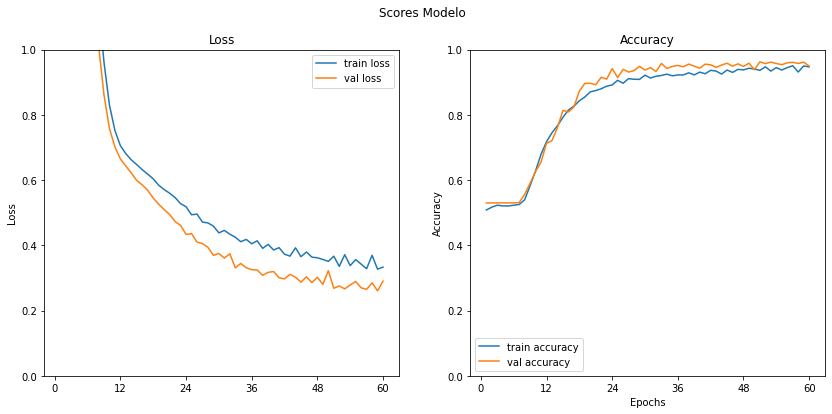

In [0]:
plot_history('Scores Modelo', history, ['train', 'val'])
plt.savefig('Scores Red.jpg', dpi=300)

En base a las predicciones ploteamos el accuracy obtenido:

In [0]:
from sklearn.metrics import accuracy_score
y_pred =model.predict_classes(X_test_vec)

print("Accuracy sobre Red: {}".format(accuracy_score(y_test, y_pred.round())))

Accuracy sobre Red: 0.9503340757238308


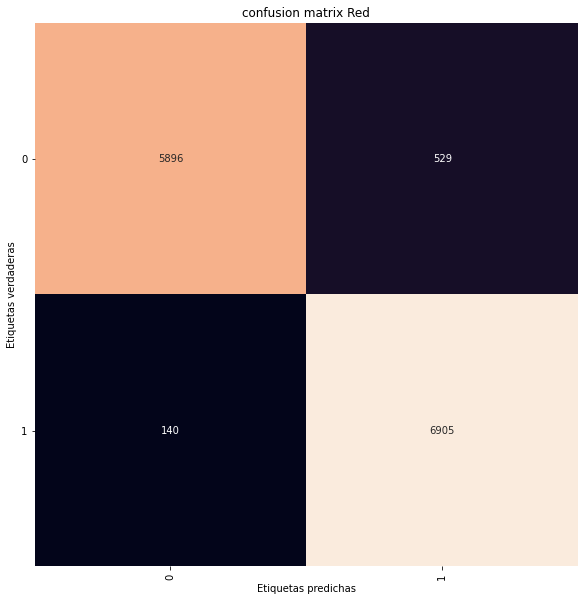

In [0]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(10, 10))
classes = unique_labels(y_test, y_pred)
plt.title("confusion matrix Red")

mat = confusion_matrix(y_test, y_pred)
ax=sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
sns.set(font_scale=2) 

plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')
ax.set_xticklabels(classes,rotation=90)
ax.set_yticklabels(classes,rotation=0);

plt.savefig('Matriz Confusion Red.jpg', dpi=300)

# **7. CONCLUSIONES**

Los modelos Benchmark alcanzaron una muy alta performance con poco esfuerzo. Lejos de alegrarnos por el resultado, además de realizar una nueva revisión sobre los datos, se desdobló el análisis sobre dos de los campos del dataset : Título y Cuerpo de la Noticia

Sobre esta decisión, el manejo de los datos sólo de Title genera una pobre disponibilidad de features que atenta directemente sobre el accuracy del modelo. No recomendamos ese camino de trabajo

Para el análisis de texto de la noticia: En el proceso recurrente se detectaron las anomalías relacionadas con filtración de información del target dentro de los features: 
* Concentración de fake News en 2 de las 7 secciones
* Noticias verdaderas con información sobre la agencia de noticias de origen.

Redes: el análisis del dataset y del manejo de los datos, pudimos ver que el algoritmo cuenta con un 94% de accuracy final  en Train  (habiendo hecho los splits de validación, test y crossvalidation) y un 95% de accuracy en Test y se comporta de manera estable en los primeros 60 epochs. 

La fortaleza de predicción no radica en la complejidad del algoritmo ya que había tenido performances similares en arquitecturas más simples con menor demanda computacional.

Encuentra dificultades con los falsos positivos, en nuestro caso, califica como falsas noticias que son en esencia verdaderas.  El Modelo Naive Bayes, por el contrario, tenía debilidad en los falsos negativos.

Los árboles de decisión eran muy similares ambos tipos de errores. 

Nuestra recomendación, por las características del problema, es mantener especial énfasis en el indicador de precisión además del accuracy, por lo que recomendamos la Red Neuronal Optimizada.
